
### **Goal:**
To build a hierarchical image classification model using MobileNetV2 for level_1 and level_2 classification tasks.

---

### **Steps Overview:**
1. **Load and Prepare the Dataset**
2. **Build the MobileNetV2 Model**
3. **Compile and Train the Model**
4. **Evaluate the Model**
5. **Visualize Results**

---

# 1. Load and Prepare the dataset 


Visualizing: aug_0_000052.jpg


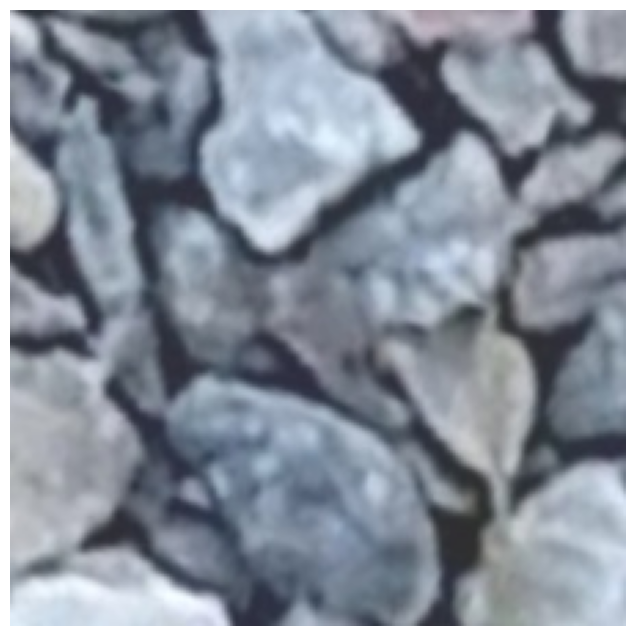

Visualizing: aug_1_000038.jpg


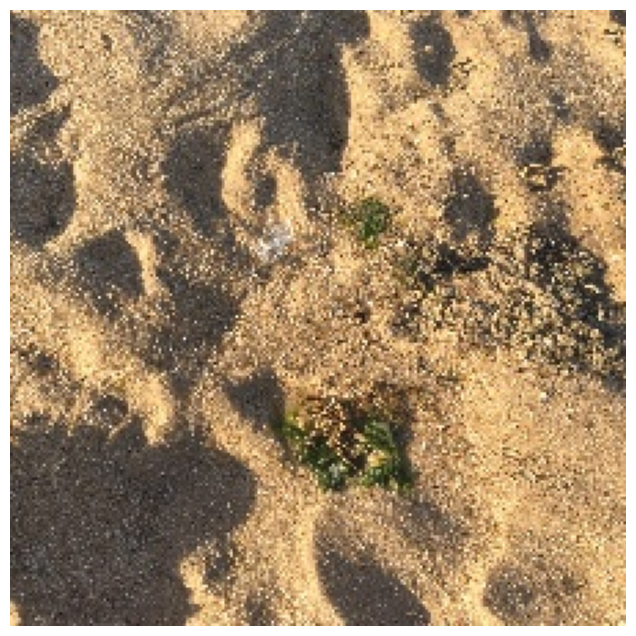

In [18]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import os

# Paths
augmented_annotations_path = "../data/split/train/augmented/augmented_annotations.json"  # Path to augmented annotations
augmented_images_dir = "../data/split/train/augmented/"  # Path to augmented images

# Load augmented annotations
with open(augmented_annotations_path, "r") as f:
    augmented_annotations = json.load(f)

# Mapping of category IDs to names (from annotations)
category_mapping = {
    cat["id"]: cat["name"] for cat in augmented_annotations["categories"]
}

# Function to visualize an image with bounding boxes and segmentation
def visualize(image_path, annotations, category_mapping):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image {image_path}. Skipping...")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create a plot
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    # Add bounding boxes and segmentation masks
    for ann in annotations:
        # Bounding box: [x_min, y_min, width, height]
        bbox = ann["bbox"]
        category_id = ann["category_id"]
        category_name = category_mapping.get(category_id, "Unknown")

        # Draw bounding box
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3],
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

        # Add label above the bounding box
        ax.text(
            bbox[0], bbox[1] - 5, category_name,
            color="white", fontsize=12, bbox=dict(facecolor="red", alpha=0.5)
        )

        # Draw segmentation polygon(s), if available
        if "segmentation" in ann and ann["segmentation"]:
            for polygon in ann["segmentation"]:
                ax.plot(
                    polygon[::2],  # x-coordinates
                    polygon[1::2],  # y-coordinates
                    color="blue", linewidth=2, alpha=0.7
                )

    plt.axis("off")
    plt.show()

# Select a sample of augmented images to visualize
for img in augmented_annotations["images"][:2]:  # Check the first 5 images
    img_path = os.path.join(augmented_images_dir, img["file_name"])

    # Get annotations for the image
    img_annotations = [
        ann for ann in augmented_annotations["annotations"]
        if ann["image_id"] == img["id"]
    ]

    print(f"Visualizing: {img['file_name']}")
    visualize(img_path, img_annotations, category_mapping)


In [26]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
import os

# Paths
augmented_annotations_path = "../data/split/train/augmented/augmented_annotations.json"
augmented_images_dir = "../data/split/train/augmented/"

# Load augmented annotations
with open(augmented_annotations_path, "r") as f:
    augmented_annotations = json.load(f)

def validate_annotation(image, annotation):
    """Validate an individual annotation."""
    image_width, image_height = image.shape[1], image.shape[0]
    bbox = annotation["bbox"]
    segmentation = annotation["segmentation"]

    # Validate bounding box
    x_min, y_min, width, height = bbox
    x_max, y_max = x_min + width, y_min + height

    bbox_valid = (
        0 <= x_min < image_width and 0 <= y_min < image_height and
        0 <= x_max <= image_width and 0 <= y_max <= image_height
    )

    # Check if bounding box dimensions are positive
    bbox_size_valid = width > 0 and height > 0

    # Validate segmentation
    segmentation_valid = True
    for polygon in segmentation:
        for i, coord in enumerate(polygon):
            if i % 2 == 0:  # X-coordinates
                if not (0 <= coord <= image_width):
                    segmentation_valid = False
            else:  # Y-coordinates
                if not (0 <= coord <= image_height):
                    segmentation_valid = False

    # Check if segmentation has at least three points (valid polygon)
    segmentation_size_valid = all(len(polygon) >= 6 for polygon in segmentation)

    # Validate area
    area_valid = annotation["area"] >= 0

    return bbox_valid, bbox_size_valid, segmentation_valid, segmentation_size_valid, area_valid

def visualize_annotation(image, annotation, category_mapping):
    """Visualize a single annotation on the image."""
    bbox = annotation["bbox"]
    segmentation = annotation["segmentation"]
    category_id = annotation["category_id"]
    category_name = category_mapping.get(category_id, "Unknown")

    # Create a plot
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    # Draw bounding box
    x_min, y_min, width, height = bbox
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor="red", facecolor="none"
    )
    ax.add_patch(rect)

    # Draw segmentation
    for polygon in segmentation:
        polygon = [(polygon[i], polygon[i + 1]) for i in range(0, len(polygon), 2)]
        poly_patch = patches.Polygon(
            polygon, closed=True, edgecolor="blue", fill=False, linewidth=2
        )
        ax.add_patch(poly_patch)

    # Add label
    ax.text(
        x_min, y_min - 5, category_name,
        color="white", fontsize=12, bbox=dict(facecolor="red", alpha=0.5)
    )

    plt.show()

# Validate and visualize annotations
category_mapping = {cat["id"]: cat["name"] for cat in augmented_annotations["categories"]}
for img in augmented_annotations["images"][:10]:  # Check the first 10 images
    img_path = os.path.join(augmented_images_dir, img["file_name"])
    image = cv2.imread(img_path)
    if image is None:
        print(f"Image {img['file_name']} not found. Skipping...")
        continue

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(f"Image ID: {img['id']}")
    print(f"Annotations for this image: {[ann for ann in augmented_annotations['annotations'] if ann['image_id'] == img['id']]}")

    img_annotations = [
        ann for ann in augmented_annotations["annotations"]
        if ann["image_id"] == img["id"]
    ]

    print(img_annotations)

    print(f"Validating: {img['file_name']}")
    
    print("got here")
    for annotation in img_annotations:

        print("in here")
        bbox_valid, bbox_size_valid, segmentation_valid, segmentation_size_valid, area_valid = validate_annotation(image, annotation)

        if not bbox_valid:
            print(f"Invalid bounding box coordinates: {annotation['bbox']} for image {img['file_name']}")
        if not bbox_size_valid:
            print(f"Invalid bounding box dimensions (width/height <= 0): {annotation['bbox']} for image {img['file_name']}")
        if not segmentation_valid:
            print(f"Invalid segmentation coordinates: {annotation['segmentation']} for image {img['file_name']}")
        if not segmentation_size_valid:
            print(f"Invalid segmentation size (too few points): {annotation['segmentation']} for image {img['file_name']}")
        if not area_valid:
            print(f"Invalid area (negative value): {annotation['area']} for image {img['file_name']}")

        # Add summary line
        if all([bbox_valid, bbox_size_valid, segmentation_valid, segmentation_size_valid, area_valid]):
            print(f"Annotation valid for image {img['file_name']}.")
            print(f"Annotation ID: {annotation['id']}, Category: {category_mapping[annotation['category_id']]}")
            print(f"BBox: {annotation['bbox']}, Segmentation: {annotation['segmentation']}")


        visualize_annotation(image, annotation, category_mapping)


Image ID: 100
Annotations for this image: []
[]
Validating: aug_0_000052.jpg
got here
Image ID: 101
Annotations for this image: []
[]
Validating: aug_1_000038.jpg
got here
Image ID: 102
Annotations for this image: []
[]
Validating: aug_2_000046.jpg
got here
Image ID: 103
Annotations for this image: []
[]
Validating: aug_3_000052.jpg
got here
Image ID: 104
Annotations for this image: []
[]
Validating: aug_4_000088.jpg
got here
Image ID: 105
Annotations for this image: []
[]
Validating: aug_5_000046.jpg
got here
Image ID: 106
Annotations for this image: []
[]
Validating: aug_6_000038.jpg
got here
Image ID: 107
Annotations for this image: []
[]
Validating: aug_7_000088.jpg
got here
Image ID: 108
Annotations for this image: []
[]
Validating: aug_8_000088.jpg
got here
Image ID: 109
Annotations for this image: []
[]
Validating: aug_9_000052.jpg
got here
